# Librerias a Usar

In [ ]:
!pip install qiskit qiskit-aer --quiet
!pip install pylatexenc --quiet
import qiskit as qk
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity, partial_trace
import matplotlib.pyplot as plt

%matplotlib inline

# Algoritmo de Teleportacion Cuantica

## Generemos el qubit qo que alice quiere transmitir

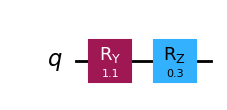

In [ ]:
def circuito_estado_misterioso(theta=1.1, phi=0.3):
    qc = QuantumCircuit(1, name="psi")
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    return qc

qc_psi = circuito_estado_misterioso()
qc_psi.draw('mpl')

In [ ]:
state_psi = Statevector.from_instruction(qc_psi)
print("Vector de estado |ψ⟩:", state_psi)

Vector de estado |ψ⟩: Statevector([0.84295159-0.12739967j, 0.51681801+0.0781094j ],
            dims=(2,))


## Preparamos el circuito


In [ ]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(2, 'c')
teleport_circuit = QuantumCircuit(qr, cr)

In [ ]:
# Insertamos el circuito de estado misterioso en q0
psi_circ = circuito_estado_misterioso()
teleport_circuit.compose(psi_circ, qubits=[qr[0]], inplace=True)

In [ ]:
# Crear el par de Bell entre q1 y q2
teleport_circuit.h(qr[1])
teleport_circuit.cx(qr[1], qr[2])

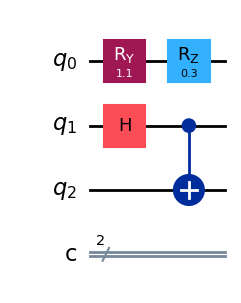

In [ ]:
teleport_circuit.draw('mpl')

## Apliquemos el Algoritmo!

In [ ]:
# Alice realiza CNOT a su par de bell y posteriormente Hadamard a su qubit a
# teleportar
teleport_circuit.cx(qr[0], qr[1])
teleport_circuit.h(qr[0])

# Medimos q0 y q1
teleport_circuit.measure(qr[0], cr[0])
teleport_circuit.measure(qr[1], cr[1])

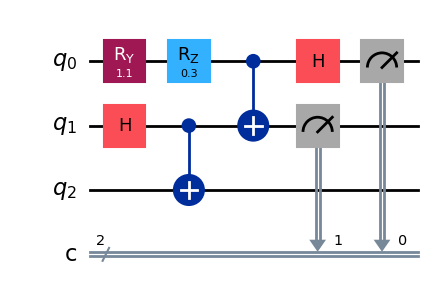

In [ ]:
teleport_circuit.draw('mpl')

In [ ]:
# Si c1 == 1 → aplicar X a q2
with teleport_circuit.if_test((cr[1], 1)):
    teleport_circuit.x(qr[2])

# Si c0 == 1 → aplicar Z a q2
with teleport_circuit.if_test((cr[0], 1)):
    teleport_circuit.z(qr[2])

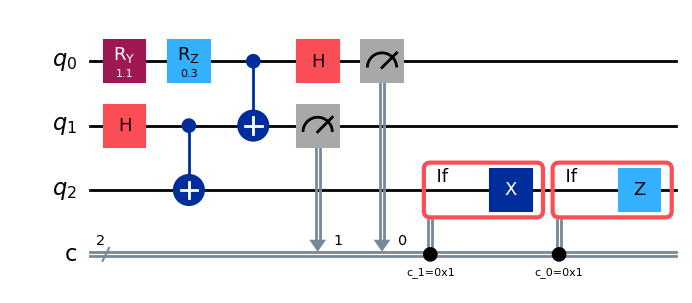

In [ ]:
teleport_circuit.draw('mpl')

 ## Simulacion

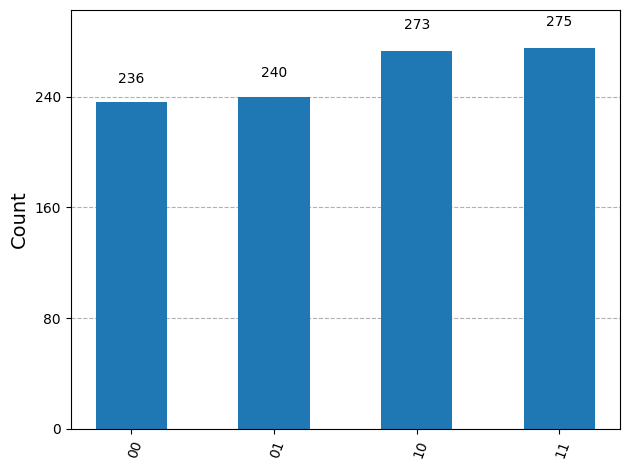

In [ ]:
sim = AerSimulator()
tcirc = transpile(teleport_circuit, sim)
result = sim.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

## Esferas de bloch segun estado del sistema

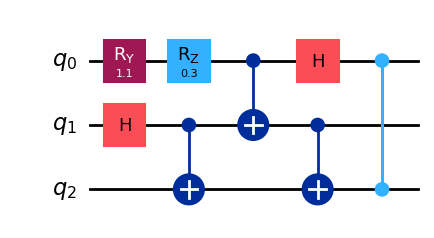

In [ ]:
def circuito_teleportacion_unitario(theta=1.1, phi=0.3):
    """
    Versión para ANALIZAR/VER teleportación.
    - 3 qubits: q0 (mensaje), q1 (Alice), q2 (Bob)
    - Sin mediciones, sin ifs.
    """
    qc = qk.QuantumCircuit(3)

    # Preparar |ψ⟩ en q0
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    # Par de Bell entre q1 y q2
    qc.h(1)
    qc.cx(1, 2)

    # Paso de teleportación (Alice)
    qc.cx(0, 1)
    qc.h(0)

    # "Correcciones" cuánticas
    qc.cx(1, 2)   # X en q2 si q1 = 1
    qc.cz(0, 2)   # Z en q2 si q0 = 1

    return qc

teleport_qc = circuito_teleportacion_unitario()
teleport_qc.draw('mpl')

In [ ]:
# Estado inicial del sistema (antes del par Bell)
state_initial = Statevector.from_instruction(circuito_teleportacion_unitario())

# Simulación coherente
state_final = Statevector.from_instruction(qc_unit)

# Matriz densidad de Bob (traza sobre q0,q1)
rho_bob = partial_trace(state_final, [0, 1])

# Matriz densidad del estado original
rho_init = DensityMatrix(state_psi)

# Fidelidad
fid = state_fidelity(rho_bob, rho_init)
print(f"Fidelidad: {fid:.6f}")


Fidelidad: 1.000000


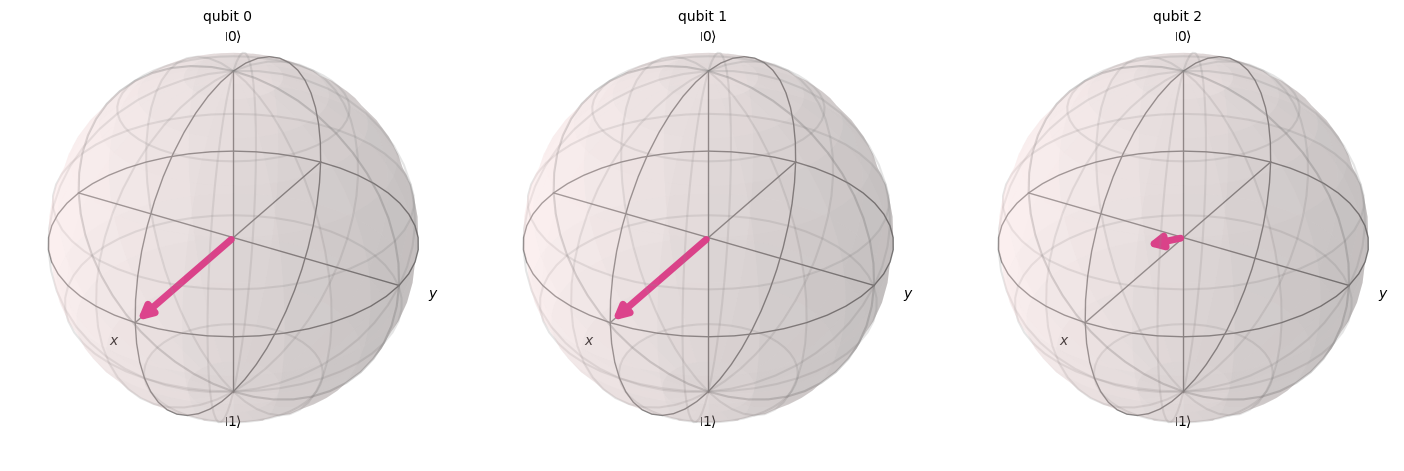

In [ ]:


circuito_teleportacion_unitario = circuito_teleportacion_unitario()

state = Statevector(circuito_teleportacion_unitario)
plot_bloch_multivector(state)


Fidelidad entre |ψ⟩ inicial (q0) y estado final de Bob (q2): 1.000000

 Estado inicial |ψ⟩ en la esfera de Bloch:


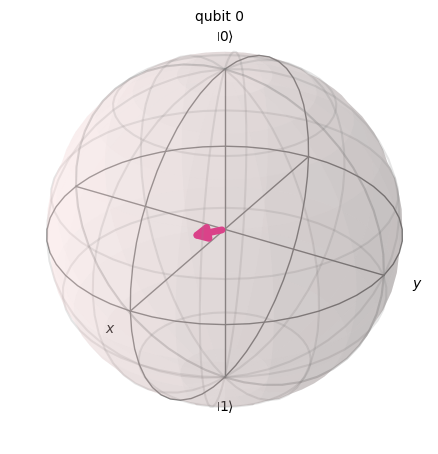


 Estado final de Bob (q2) en la esfera de Bloch:


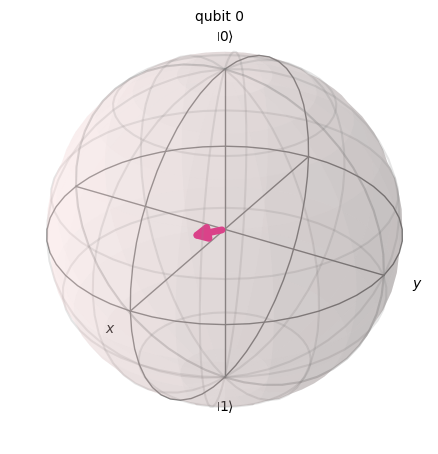

In [ ]:
# Estado inicial |ψ⟩
state_init = state_psi
rho_init = DensityMatrix(state_init)

# Estado final después del circuito unitario (3 qubits)
state_final = Statevector(teleport_qc)

# Extraemos el estado de Bob (qubit 2)
rho_bob = partial_trace(state_final, [0, 1])   # trazar q0 y q1

# Fidelidad entre estado inicial y teletransportado
fid = state_fidelity(rho_bob, rho_init)
print(f"Fidelidad entre |ψ⟩ inicial (q0) y estado final de Bob (q2): {fid:.6f}")


print("\n Estado inicial |ψ⟩ en la esfera de Bloch:")
display(plot_bloch_multivector(state_init))

print("\n Estado final de Bob (q2) en la esfera de Bloch:")
display(plot_bloch_multivector(rho_bob))

